# AlexNet implementation (with PyTorch)
Model from: https://pytorch.org/hub/pytorch_vision_alexnet/

Training loop from: https://kushaj.medium.com/training-alexnet-with-tips-and-checks-on-how-to-train-cnns-practical-cnns-in-pytorch-1-61daa679c74a

## Import required modules

In [1]:
import torch
from torch import nn, optim
from copy import deepcopy
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import time
import os
from glob import glob

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
netsPath = '../nets/'

cpu


In [2]:
import random
random.seed(1234) # reproducibility seed

## Get model

### Get pretrained model from source

In [3]:
alexnet = torch.load(netsPath + "Alexnet_preTrained.pth")
#alexnet.eval()

## Data transformation

Set number of classifications labels

In [4]:
labels_list = ["DME", "NORMAL"]
num_labels = len(labels_list)

In [5]:
data_dir = '/volume/OCT/OCT2017/'
sets = ["train", "val", "test"]

In [6]:
class customImageFolderDataset(Dataset):
    """Custom Image Loader dataset."""
    def __init__(self, root, labels=None, transform=None):
        """
        Args:
            root (string): Path to the images organized in a particular folder structure.
            transform: Any Pytorch transform to be applied
        """
        if labels:
            # Sort all labels alphabetically
            tempLabels = sorted(set(labels))
            
            # Get all image paths from a directory
            self.image_paths = []
            for lab in labels:
                paths = glob(f"{root}/{lab}/*")
                if not len(paths):
                    print(f"No data for {lab} label. Removing it")
                    self.tempLabels.remove(lab)
                self.image_paths += paths
        else:
            # Get all image paths from a directory
            self.image_paths = glob(f"{root}/*/*")
            
        # Get the labels from the image paths
        self.labels = [x.split("/")[-2] for x in self.image_paths]
        
        # Create a dictionary mapping each label to a index from 0 to len(classes).
        self.label_to_idx = {x:i for i,x in enumerate(set(self.labels))}
        self.transform = transform
        
    def __len__(self):
        # return length of dataset
        return len(self.image_paths)
      
    def __getitem__(self, idx):
        # open and send one image and label
        img_name = self.image_paths[idx]
        label = self.labels[idx]
        image = self.preprocessImage(img_name, transform)
        
        return image, self.label_to_idx[label]
    
    # Load image form given path and convert into RGB mode
    def preprocessImage(self, path, transform=None):
        im = Image.open(path)
        if im.mode != "RGB":
            im = im.convert("RGB")
        if transform:
            im = transform(im)
        return im

In [7]:
batch_size = 32 # prefered by alexnet
size = 224 # given by alexnet

transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [8]:
image_datasets = {
    set_type : customImageFolderDataset(root=data_dir + set_type, labels=labels_list, transform=transform)
    for set_type in sets
}

data_loader = {
    x: torch.utils.data.DataLoader(image_datasets[x],
                                   batch_size=batch_size,
                                   shuffle=True,
                                   pin_memory=True) for x in sets
}

Sets shape

In [9]:
for set_type in sets:
    print(f"Set: {set_type}. Images: {len(data_loader[set_type].dataset)}")

Set: train. Images: 37663
Set: val. Images: 16
Set: test. Images: 484


Check labels and images

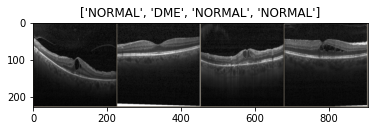

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Our images are normalized so denormalize then and convert them to numpy
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std*img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    


images, labels = next(iter(data_loader['val']))
grid_img = make_grid(images[:4], nrow=4)
imshow(grid_img, title = [labels_list[x] for x in labels[:4]])

## IMO model

### Modify architecture

In [11]:
def newAlexNet(num_labels):
    newAlexnet = deepcopy(alexnet)
    lastLayer = newAlexnet.classifier[-1] # get usual last layer
    newAlexnet.classifier[-1] = nn.Linear(lastLayer.in_features, num_labels) # modify last layer number of outputs (labels to be classified)
    return newAlexnet

imoAlexnet = newAlexNet(num_labels)

### Set hiperparameters

In [12]:
learning_rate = 0.001
momentum = 0.9
epochs = 3

### Loss function, optimizer and scheduler

In [13]:
loss_fn = nn.CrossEntropyLoss()
#optimizer = optim.SGD(imoAlexnet.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(imoAlexnet.parameters(), lr=learning_rate)
optimizer = optim.Adagrad(imoAlexnet.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

### Train loop

In [14]:
def train(model, data_loader, criterion, optimizer, scheduler = None, num_epochs=100, seed=None):
    since = time.time()
    if seed:
        random.seed(seed)
    
    train_batch_loss = []
    train_epoch_loss = []
    val_epoch_loss = []
    
    model.to(device)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*15)
        
        # You perform validation test after every epoch
        for phase in ["train", "val"]:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0; running_corrects = 0;
            
            num_batches = int(len(data_loader[phase].dataset) / batch_size)
            
            for idx, (inputs, labels) in enumerate(data_loader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero accumulated gradients
                optimizer.zero_grad()
                
                # During train phase we want to remember history for grads
                # and during val we do not want history of grads
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if idx%200 == 0 or idx == num_batches - 1:
                        train_batch_loss.append(loss.item())
                        print('Epoch {}: {}/{} steps in progress'.format(epoch+1, idx+1, num_batches))
                        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = running_corrects.double() / len(data_loader[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                val_epoch_loss.append((epoch_loss, epoch_acc))
                if scheduler:
                    scheduler.step(loss.item())
            else:
                train_epoch_loss.append((epoch_loss, epoch_acc))
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return model

### Train model with train set

In [15]:
trainedImoModel = train(imoAlexnet, data_loader, loss_fn, optimizer, scheduler, epochs, seed=123)

Epoch 1/3
---------------
Epoch 1: 1/1176 steps in progress
Epoch 1: 201/1176 steps in progress
Epoch 1: 401/1176 steps in progress
Epoch 1: 601/1176 steps in progress
Epoch 1: 801/1176 steps in progress
Epoch 1: 1001/1176 steps in progress
Epoch 1: 1176/1176 steps in progress
train Loss: 0.3188 Acc: 0.8641
Epoch 1: 1/0 steps in progress
val Loss: 0.0134 Acc: 1.0000

Epoch 2/3
---------------
Epoch 2: 1/1176 steps in progress
Epoch 2: 201/1176 steps in progress
Epoch 2: 401/1176 steps in progress
Epoch 2: 601/1176 steps in progress
Epoch 2: 801/1176 steps in progress
Epoch 2: 1001/1176 steps in progress
Epoch 2: 1176/1176 steps in progress
train Loss: 0.0992 Acc: 0.9671
Epoch 2: 1/0 steps in progress
val Loss: 0.0017 Acc: 1.0000

Epoch 3/3
---------------
Epoch 3: 1/1176 steps in progress
Epoch 3: 201/1176 steps in progress
Epoch 3: 401/1176 steps in progress
Epoch 3: 601/1176 steps in progress
Epoch 3: 801/1176 steps in progress
Epoch 3: 1001/1176 steps in progress
Epoch 3: 1176/1176 

Evaluate model over test set

In [16]:
def calculateConfusionMatrix(model, labs, data_loader, set_name, plot=False):
    num_labels = len(labs)
    confMatrix = np.zeros((num_labels, num_labels), dtype=int)
    model.eval()
    for batchNum, (inputs, labels) in enumerate(data_loader[set_name]):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for i, pred in enumerate(preds):
            confMatrix[pred, labels[i]] += 1
        
    testAcc = confMatrix.trace() / confMatrix.sum()
    if plot:
        plotConfusionMatrix(labs, confMatrix)
    return testAcc, confMatrix
        
def plotConfusionMatrix(labels, confMatrix):
    import seaborn as sns
    x_axis_labels = labels # labels for x-axis
    y_axis_labels = labels # labels for y-axis
    ax = sns.heatmap(confMatrix, cmap="Blues", annot=True, fmt="d", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion matrix");
    plt.show()

### Evaluate model

#### Train evaluation

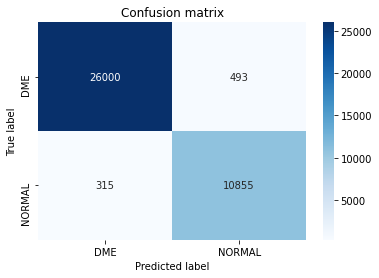

Train set accuracy: 0.978546584180761


In [17]:
trainedImoModel.eval() # set model to be evaluated (ignore grads)
trnAcc, trnConfMatrix = calculateConfusionMatrix(trainedImoModel, labels_list, data_loader, "train", plot=True)
print(f'Train set accuracy: {trnAcc}')

In [18]:
trnAccLabel = {labels_list[lab]: trnConfMatrix[lab, lab] / sum(trnConfMatrix[:, lab]) for lab in range(num_labels)}
print(f"Train accuracy by label: {trnAccLabel}")

Train accuracy by label: {'DME': 0.9880296408892266, 'NORMAL': 0.9565562213605922}


#### Test evaluation

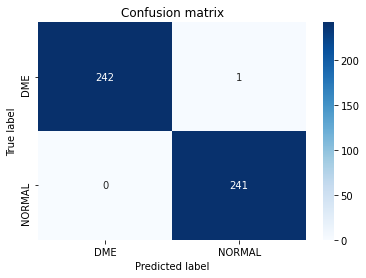

Test set accuracy: 0.9979338842975206


In [19]:
trainedImoModel.eval() # set model to be evaluated (ignore grads)
tstAcc, tstConfMatrix = calculateConfusionMatrix(trainedImoModel, labels_list, data_loader, "test", plot=True)
print(f'Test set accuracy: {tstAcc}')

In [20]:
tstAccLabel = {labels_list[lab]: tstConfMatrix[lab, lab] / sum(tstConfMatrix[:, lab]) for lab in range(num_labels)}
print(f"Test accuracy by label: {tstAccLabel}")

Test accuracy by label: {'DME': 1.0, 'NORMAL': 0.9958677685950413}


Save model into files (saved models listed in file)

In [21]:
netVer = len(os.listdir(netsPath))
netType = "alexnet"
netID = "_".join([netType, str(netVer), '_'.join(labels_list)])
torch.save(trainedImoModel, netsPath + netID + ".pth")

Load saved model (if needed)

In [22]:
model = torch.load(path + netID + ".pth")
model.eval()

NameError: name 'path' is not defined